In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Data

In [2]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from pathlib import Path
from matplotlib import pyplot
from math import log
from tqdm import tqdm_notebook as tqdm
import time
import random
from torchvision.models import vgg16_bn
import IPython.core.debugger as pdb
import numpy as np

torch.cuda.set_device(0)

In [3]:
PATH = Path('/mnt/data4T1/vozman/imagenet/')
PATH_TRN = PATH/'train'

In [4]:
img_paths = list(map(str,(PATH_TRN.glob('**/*.JPEG'))))
img_paths[:5]

['/mnt/data4T1/vozman/imagenet/train/n01644373/n01644373_1037.JPEG',
 '/mnt/data4T1/vozman/imagenet/train/n01644373/n01644373_10622.JPEG',
 '/mnt/data4T1/vozman/imagenet/train/n01644373/n01644373_11020.JPEG',
 '/mnt/data4T1/vozman/imagenet/train/n01644373/n01644373_11093.JPEG',
 '/mnt/data4T1/vozman/imagenet/train/n01644373/n01644373_11474.JPEG']

In [5]:
scale = 4
size_lr = 72
size_hr = size_lr * scale
bs = 8

device = torch.device("cuda:0")

In [6]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [7]:
class SuperResolutionDataset(torch.utils.data.Dataset):
    def __init__(self, samples, sz_x, sz_y, transform=None, loader=pil_loader):
        self.samples = samples
        self.loader = loader
        
        self.transform = transform
        resize = lambda sz: transforms.Compose([transforms.Resize((sz, sz)), transforms.ToTensor()])
        
        self.tfm_x = resize(sz_x)
        self.tfm_y = resize(sz_y)
        
        self.apply_train_transforms = True

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
                
        path = self.samples[index]
        img = self.loader(path)
        
        if self.transform is not None and self.apply_train_transforms:
            img = self.transform(img)
        
        sample = self.tfm_x(img)
        target = self.tfm_y(img)
        
        return sample, target

In [8]:
dataset = SuperResolutionDataset(img_paths, size_lr, size_hr,
                                 transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                                     transforms.RandomVerticalFlip(p=0.5),]))

In [9]:
def show_img(img, ax=None):
    if ax is None: fig,ax = pyplot.subplots()
    ax.imshow(img.numpy().transpose((1, 2, 0)))
    ax.axis('off')

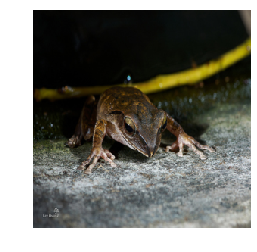

In [10]:

show_img(dataset[9][1])

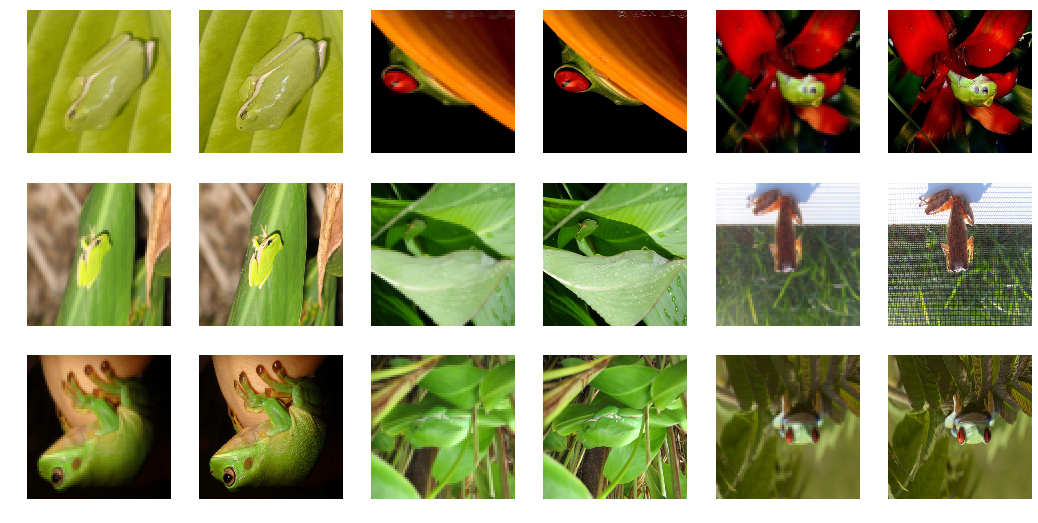

In [11]:
fig, axes = pyplot.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate([dataset[i] for i in range(9)]):
    show_img(x, ax=axes.flat[i*2])
    show_img(y, ax=axes.flat[i*2+1])

In [12]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(17495, 1944)

In [13]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=8)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True, num_workers=8)

In [14]:
dataloaders = {
    'train': train_dl,
    'val': test_dl,
}

### Model

In [15]:
def get_conv(in_channels, out_channels, kernel_size=3, actn=True):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)]
    if actn: layers.append(nn.ReLU())
    
    return nn.Sequential(*layers)
    

In [16]:
class ResSequential(nn.Module):
    def __init__(self, layers, mult):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.mult = mult
    
    def forward(self, input):
        return input + self.layers(input) * self.mult

In [17]:
def res_block(num_features):
    layers = [get_conv(num_features, num_features),
              get_conv(num_features, num_features, actn=False)]
    return ResSequential(layers, 0.1)

In [18]:
def upsample(in_channels, out_channels, scale):
    layers = []
    for i in range(int(log(scale, 2))):
        layers += [get_conv(in_channels, out_channels * 4), nn.PixelShuffle(2)]
        
    return nn.Sequential(*layers)

In [19]:
class SuperResNet(nn.Module):
    def __init__(self, scale, nf=64):
        super().__init__()
        
        layers = [
            get_conv(3, nf),
            *[res_block(nf) for i in range(8)],
            upsample(nf, nf, scale),
            nn.BatchNorm2d(nf),
            get_conv(nf, 3, actn=False),
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [20]:
model = SuperResNet(scale)

model = model.to(device)

model

SuperResNet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (3): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): 

### Pixel loss

In [21]:
criterion = nn.MSELoss()

### Pixel loss Training

In [22]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()
    

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
#                     pdb.set_trace()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

train_model(model, dataloaders, criterion, optimizer)

Epoch 0/4
----------


train Loss: 0.0091


val Loss: 0.0065

Epoch 1/4
----------


train Loss: 0.0068


val Loss: 0.0043

Epoch 2/4
----------


train Loss: 0.0064


val Loss: 0.0033

Epoch 3/4
----------


train Loss: 0.0061


val Loss: 0.0029

Epoch 4/4
----------


train Loss: 0.0054


val Loss: 0.0031


Training complete in 20m 4s


SuperResNet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (3): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): 

In [24]:
torch.save(model, './pixel_model.pt')

/home/vozman/venv/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SuperResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/vozman/venv/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type ResSequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Pixel Loss Evaluation

In [25]:
model_pixel = torch.load('./pixel_model.pt')
model_pixel.eval()

SuperResNet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (3): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): 

In [69]:
def plot(samples, titles=[f'Resized to ({size_lr},{size_lr}) images', 'Original images', 'Predictions']):
    _,axes=pyplot.subplots(len(samples), len(samples[0]), figsize=(28,7 * len(samples)))
    
    [axes[0, i].set_title(title) for i, title in enumerate(titles)]
    
    for i, imgs in enumerate(samples):
        [show_img(img, ax=axes[i, j]) for j, img in enumerate(imgs)]

In [27]:
def predict(models, x):
    return [model(x.to(device).unsqueeze(0)).squeeze().cpu().detach() for model in models]

In [28]:
def get_random_samples(n):
    test_dataset.dataset.apply_train_transforms = False
    random_samples = [random.choice(test_dataset) for i in range(n)]
    test_dataset.dataset.apply_train_transforms = True
    return random_samples

In [29]:
def predict_random_samples(models, n):
 
    random_samples = get_random_samples(n)
    
    random_pred = [[x, y, *predict(models, x)] for x, y in random_samples]
    
    return random_pred   

In [75]:
samples = predict_random_samples([model_pixel], 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


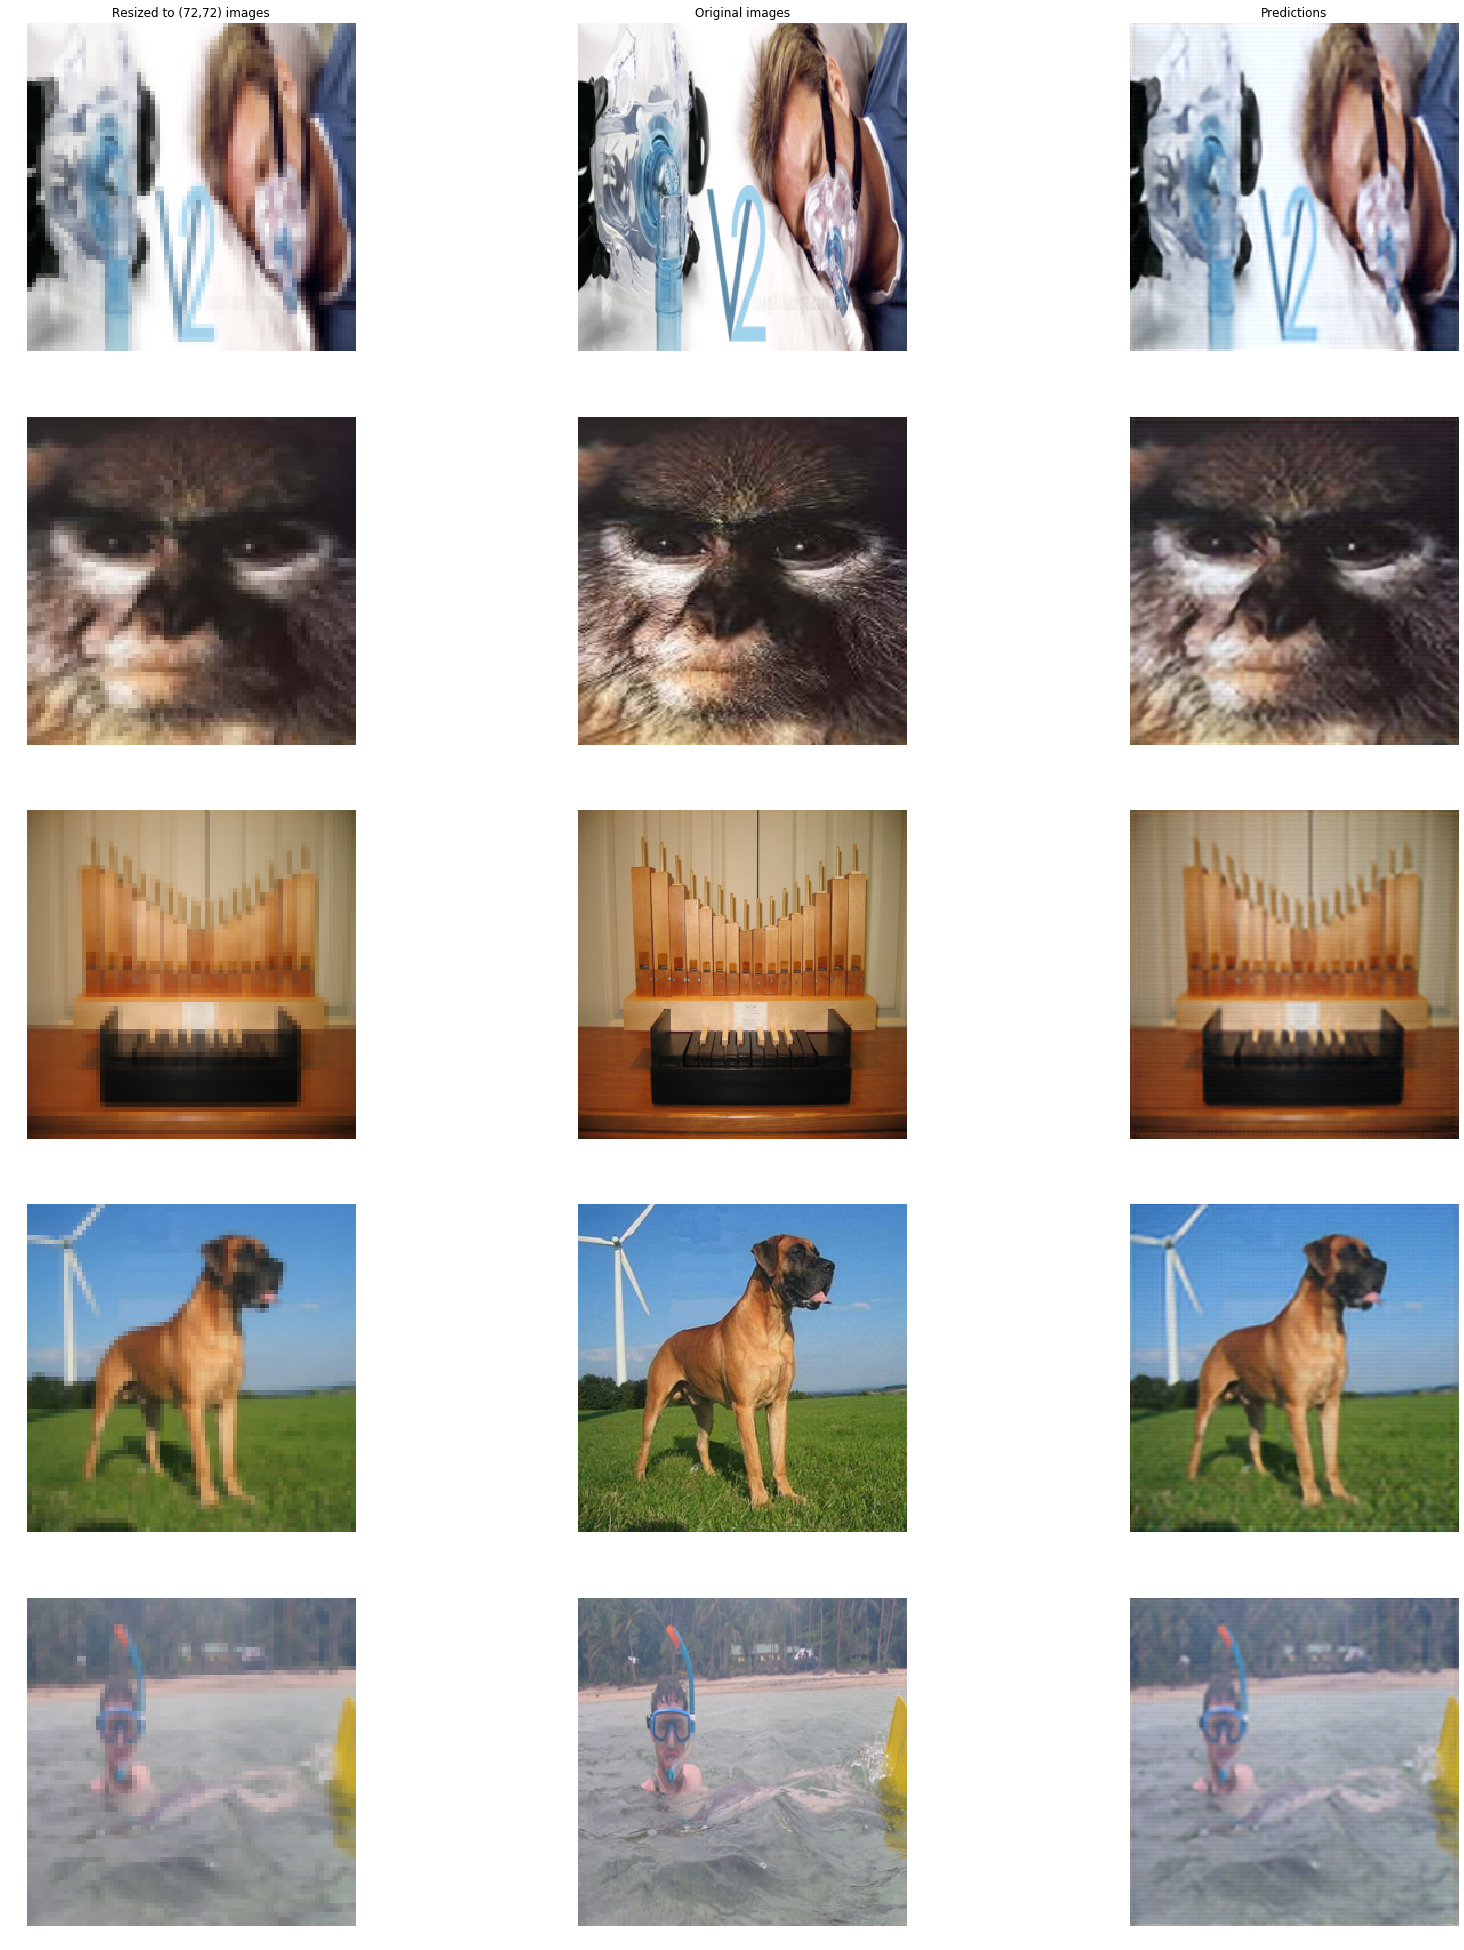

In [76]:
plot(samples)

## Perceptual Loss

In [32]:
vgg = vgg16_bn(True)

In [33]:
ids = []
for idx, layer in enumerate(list(nn.Module.children(vgg))[0]):
    if isinstance(layer, nn.MaxPool2d):
        ids += [idx-1]
ids

[5, 12, 22, 32, 42]

In [34]:
vgg = nn.Sequential(*list(nn.Module.children(vgg))[0][:13]).cuda().eval()

for params in vgg.parameters():
    params.requires_grad = False

In [35]:
class FeatureHook:
    features = None
    def __init__(self, model):
        self.hook = model.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

In [36]:
class PerceptualLoss(nn.Module):
    def __init__(self, model, layer_ids, layer_wgts):
        super().__init__()
        self.m = model
        self.layer_wgts = layer_wgts
        
        layers = list(model.children())
        self.hooks = [FeatureHook(layers[i]) for i in layer_ids]
    
    def forward(self, prediction, target):
        pixel_loss = nn.functional.l1_loss(prediction, target) / 100
    
        self.m(target)
        target_features = [hook.features.clone() for hook in self.hooks]
        
        self.m(prediction)
        prediction_features = [hook.features.clone() for hook in self.hooks]
        
        losses = [nn.functional.l1_loss(prediction_feature, target_feture) * wgt
                  for prediction_feature, target_feture, wgt
                  in zip(prediction_features, target_features, self.layer_wgts)]
        
        losses += [pixel_loss]
#         print(losses)
        
        return sum(losses)
    
    def close(self):
        [hook.close for hook in self.hooks]
        

In [37]:
perceptual_loss = PerceptualLoss(vgg, ids[:2], [0.26,0.74])

### icnr

In [38]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [39]:
p_shuffle1 = model.model[-3][0][0]
p_shuffle2 = model.model[-3][2][0]

In [40]:
def init_pre_pixel_shuffle(conv_shuffle):
    kernel = icnr(conv_shuffle.weight, scale=scale)
    conv_shuffle.weight.data.copy_(kernel);
init_pre_pixel_shuffle(p_shuffle1)
init_pre_pixel_shuffle(p_shuffle2)

/home/vozman/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.


### Training with Perceptual loss

In [41]:
model = SuperResNet(scale)

model = model.to(device)

init_pre_pixel_shuffle(p_shuffle1)
init_pre_pixel_shuffle(p_shuffle2)

/home/vozman/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.


In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

train_model(model, dataloaders, perceptual_loss, optimizer)

Epoch 0/4
----------


train Loss: 0.0462


val Loss: 0.0433

Epoch 1/4
----------


train Loss: 0.0362


val Loss: 0.0322

Epoch 2/4
----------


train Loss: 0.0306


val Loss: 0.0286

Epoch 3/4
----------


train Loss: 0.0278


val Loss: 0.0270

Epoch 4/4
----------


train Loss: 0.0271


val Loss: 0.0266


Training complete in 40m 47s


SuperResNet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (3): ResSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (1): 

In [43]:
torch.save(model, './percept_model.pt')

### Evaluating model with perceptual loss

In [44]:
model_perceptual = torch.load('./percept_model.pt')
model_perceptual.eval();

In [77]:
samples = predict_random_samples([model_pixel, model_perceptual], 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

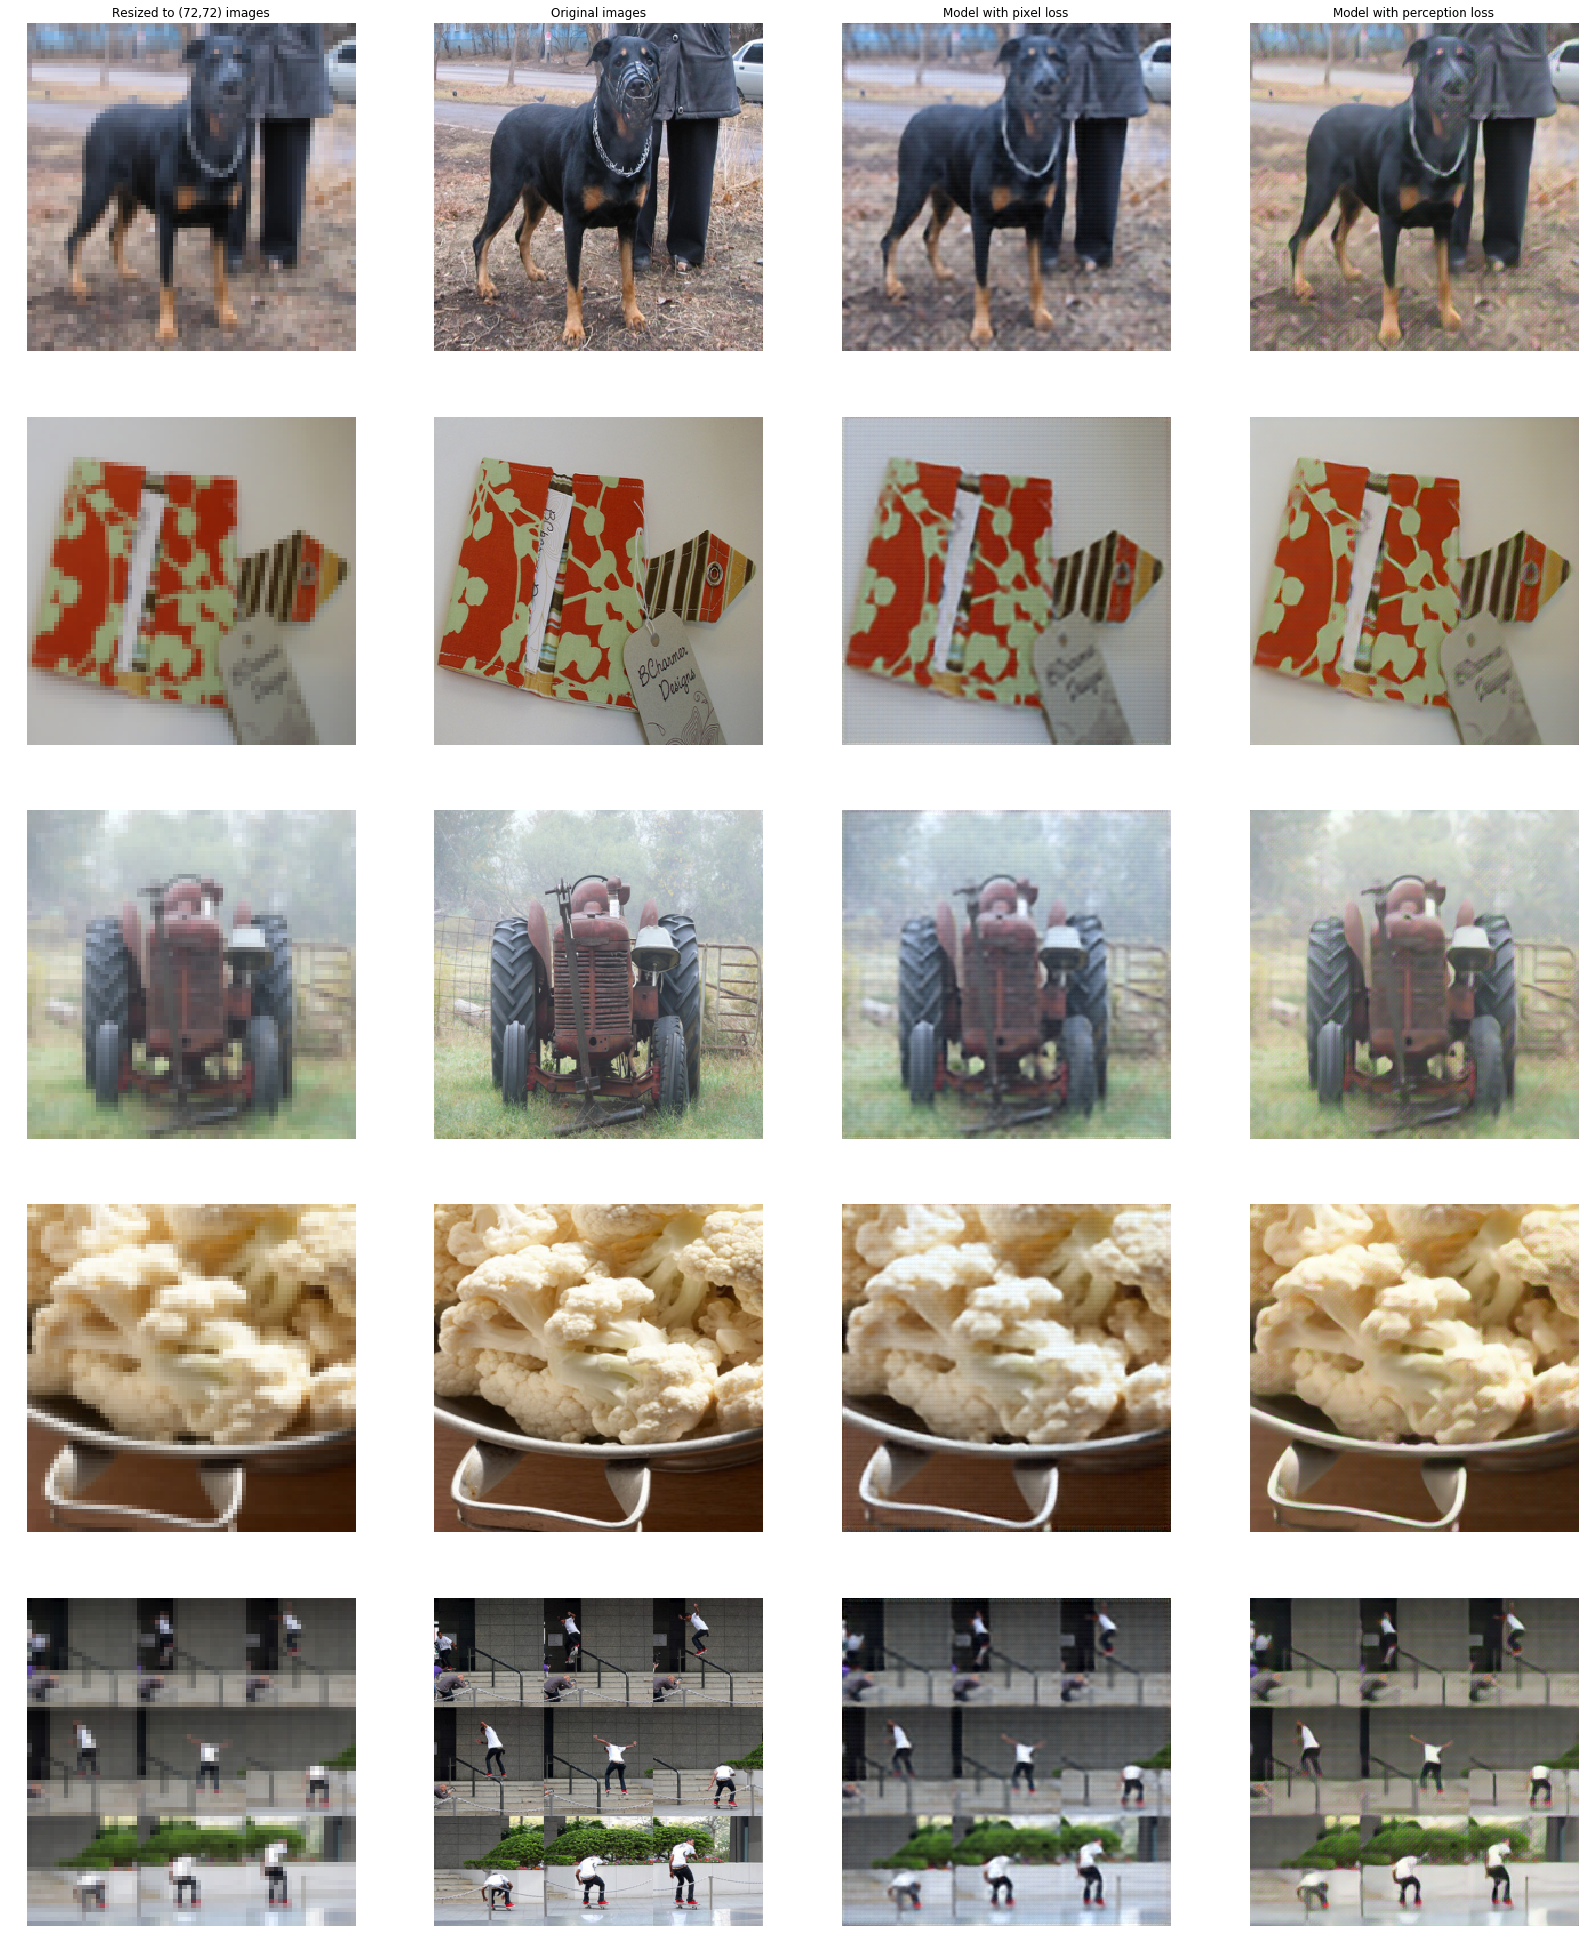

In [78]:
plot(samples, [f'Resized to ({size_lr},{size_lr}) images', 
               'Original images',
               'Model with pixel loss',
               'Model with perception loss'])